In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve, StratifiedKFold,train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import RandomForestRegressor

from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from IPython.display import display

%matplotlib inline
pd.options.mode.chained_assignment = None

In [2]:
train = pd.read_csv("../Titanic/train.csv")
test = pd.read_csv("../Titanic/test.csv")

# combine the train and test dataset for easier treatment
data = train.append(test)
data.reset_index(inplace=True, drop=True)

submit = pd.read_csv('../Titanic/gender_submission.csv')

In [3]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## to see if there's any missing data

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


missing data in Age and Cabin.

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


missing data in Age, Fare and Cabin.

To see wt the data distribution is like:

In [6]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


# Overview of the entire dataset

In order to select/ combine (i.e. simplify) features for classifications.

## Data Analysis

The final target is to see passengers survive or not. So see how it is distributed.

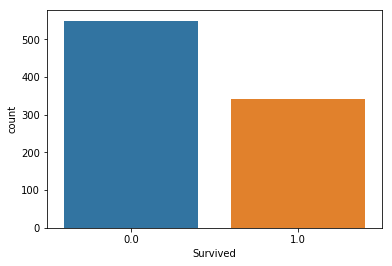

In [8]:
sns.countplot(data['Survived']);

### What factors would it be relevant to whether ppl can survive or not?

### Basic Factors

 pclass?

,Pclass,Survived
0,1,0.630
1,2,0.473
2,3,0.242


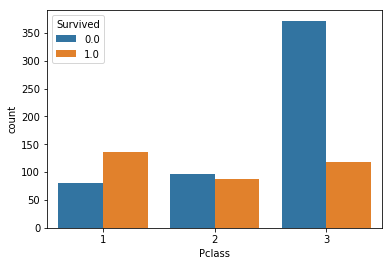

In [9]:
sns.countplot(data['Pclass'], hue=data['Survived']);
data[["Pclass", "Survived"]].groupby(
    ['Pclass'], as_index=False).mean().round(3)

Gender?

,Sex,Survived
0,female,0.742
1,male,0.189


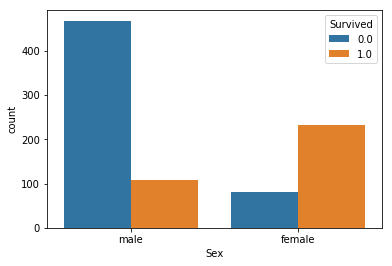

In [10]:
sns.countplot(data['Sex'], hue=data['Survived']);
data[["Sex", "Survived"]].groupby(
    ['Sex'], as_index=False).mean().round(3)

In [11]:
# Convert Sex label to a num
data['Sex_Code']=data['Sex'].map({'male':1,'female':0}).astype('int')
train=data[:len(train)]
test=data[len(train):]

# Do a rough classification and use it as a baseline for the training later
X_trn=train.drop(labels=['Survived','PassengerId'],axis=1)
Y_trn=train['Survived']

Base=['Sex_Code','Pclass']

Base_Model=RandomForestClassifier(random_state=2,n_estimators=50,
                                  min_samples_split=20,oob_score=True)
Base_Model.fit(X_trn[Base],Y_trn)

print('Base oob score :%.5f' %(Base_Model.oob_score_))

Base oob score :0.76768


will be used as reference base score

In [65]:
# Try other classification methods: Linear SVM (LinearSVC) 
# and KernalSVM (SVC)

SVM_model=LinearSVC()
SVM_model.fit(X_trn[Base],Y_trn)

print('Linear SVM score=',SVM_model.score(X_trn[Base],Y_trn))

kernel_SVM_model=SVC(kernel='rbf') #radial basis fun mapping
kernel_SVM_model.fit(X_trn[Base],Y_trn)

print('Kernel SVM score=',kernel_SVM_model.score(X_trn[Base],Y_trn))

Linear SVM score= 0.7867564534231201
Kernel SVM score= 0.7867564534231201


### More factors

### Fares

,Fare
Survived,
0.0,22.118
1.0,48.395


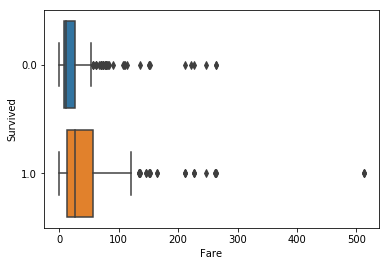

In [20]:
sns.boxplot(y='Survived',x='Fare',data=data,orient='h')
data[["Survived", "Fare"]].groupby(
    ['Survived'], as_index=True).mean().round(3)

can see that generally ppl w more expensive fares have a higher survival rate

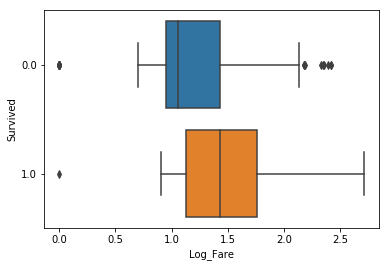

In [21]:
#try a log plot

data['Log_Fare'] = (data['Fare']+1).map(
    lambda x : np.log10(x) if x > 0 else 0)
sns.boxplot(y='Survived',x='Log_Fare',data=data,orient='h')

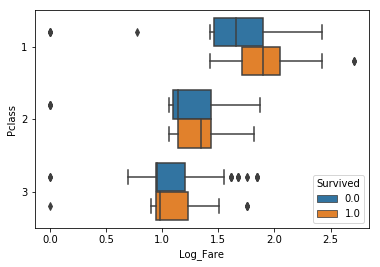

In [22]:
#see if there is any variation w diff Pclass

sns.boxplot(y='Pclass',x='Log_Fare',hue='Survived',data=data,orient='h')

To see what is the best if divide the fare into different bins

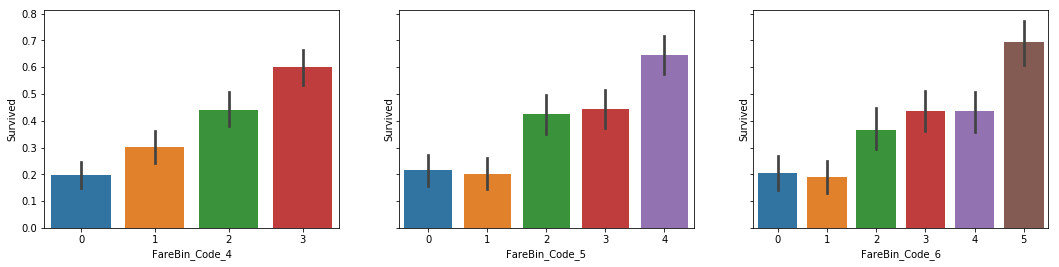

In [23]:
# Fill the missing values with the median
# since there's only one missing value
data['Fare'] = data['Fare'].fillna(data['Fare'].median())

# Making Bins
data['FareBin_4'] = pd.qcut(data['Fare'], 4)
data['FareBin_5'] = pd.qcut(data['Fare'], 5)
data['FareBin_6'] = pd.qcut(data['Fare'], 6)

label = LabelEncoder()
data['FareBin_Code_4'] = label.fit_transform(data['FareBin_4'])
data['FareBin_Code_5'] = label.fit_transform(data['FareBin_5'])
data['FareBin_Code_6'] = label.fit_transform(data['FareBin_6'])

# cross tab
df_4 = pd.crosstab(data['FareBin_Code_4'],data['Pclass'])
df_5 = pd.crosstab(data['FareBin_Code_5'],data['Pclass'])
df_6 = pd.crosstab(data['FareBin_Code_6'],data['Pclass'])

# plots
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, sharey=True)
fig.set_figwidth(18)

g1 = sns.factorplot(x='FareBin_Code_4', y="Survived", 
                    data=data,kind='bar',ax=ax1)
g2 = sns.factorplot(x='FareBin_Code_5', y="Survived", 
                    data=data,kind='bar',ax=ax2)
g3 = sns.factorplot(x='FareBin_Code_6', y="Survived", 
                    data=data,kind='bar',ax=ax3)

# close FacetGrid object
plt.close(g1.fig)
plt.close(g2.fig)
plt.close(g3.fig)

#### Use RFE to select which dividing way is the best

In [24]:
# splits again after adding the new features
train = data[:len(train)]
test = data[len(train):]

# Training set and labels
X_trn = train.drop(labels=['Survived','PassengerId'],axis=1)
Y_trn = train['Survived']

In [25]:
# No "random_state"
compare = ['Sex_Code','Pclass',
           'FareBin_Code_4','FareBin_Code_5','FareBin_Code_6']
selector = RFECV(RandomForestClassifier(
    n_estimators=250,min_samples_split=20),cv=10,n_jobs=-1)
selector.fit(X_trn[compare], Y_trn)
print(selector.support_)
print(selector.ranking_)
print(selector.grid_scores_*100)

[ True  True  True  True  True]
[1 1 1 1 1]
[78.66981614 77.33398593 78.90330269 79.13057542 80.25544774]


In [27]:
# w "random_state"
score_b4,score_b5, score_b6 = [], [], []
seeds = 10
for i in range(seeds):
    diff_cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=i)
    selector = RFECV(RandomForestClassifier(
        random_state=i,n_estimators=250,min_samples_split=20),
                     cv=diff_cv,n_jobs=-1)
    selector.fit(X_trn[compare], Y_trn)
    score_b4.append(selector.grid_scores_[2])
    score_b5.append(selector.grid_scores_[3])
    score_b6.append(selector.grid_scores_[4])

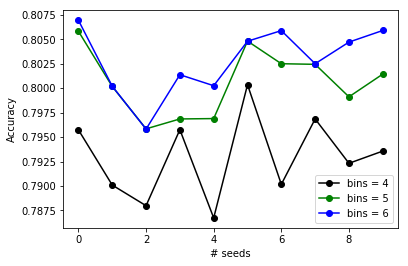

In [28]:
# scores of cases w random state 
plt.plot(range(seeds), score_b4,'-ok',label='bins = 4')
plt.plot(range(seeds), score_b5,'-og',label='bins = 5')
plt.plot(range(seeds), score_b6,'-ob',label='bins = 6')
plt.xlabel('# seeds')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [29]:
b4, b5, b6 = ['Sex_Code', 'Pclass','FareBin_Code_4'],['Sex_Code','Pclass','FareBin_Code_5'],['Sex_Code','Pclass','FareBin_Code_6']
b4_Model = RandomForestClassifier(
    random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
b4_Model.fit(X_trn[b4], Y_trn)
b5_Model = RandomForestClassifier(
    random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
b5_Model.fit(X_trn[b5], Y_trn)
b6_Model = RandomForestClassifier(
    random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
b6_Model.fit(X_trn[b6], Y_trn)
print('b4 oob score :%.5f' %(b4_Model.oob_score_),'   LB_Public : 0.7790')
print('b5 oob score :%.5f '%(b5_Model.oob_score_),' LB_Public : 0.79425')
print('b6 oob score : %.5f' %(b6_Model.oob_score_), '  LB_Public : 0.77033')

b4 oob score :0.80584    LB_Public : 0.7790
b5 oob score :0.81033   LB_Public : 0.79425
b6 oob score : 0.80135   LB_Public : 0.77033


In [104]:
# submits
X_Submit = test.drop(labels=['PassengerId'],axis=1)

b5_pred = b5_Model.predict(X_Submit[b5])

submit = pd.DataFrame({"PassengerId": test['PassengerId'],
                      "Survived":b5_pred.astype(int)})

submit.to_csv("submit_b5.csv",index=False)

In [32]:
# Try other classification methods: Linear SVM (LinearSVC) 
# and KernalSVM (SVC)

SVM_model=LinearSVC()
SVM_model.fit(X_trn[b4],Y_trn)
SVM_model.fit(X_trn[b5],Y_trn)
SVM_model.fit(X_trn[b6],Y_trn)

print('Linear SVM score (b4)=',SVM_model.score(X_trn[b4],Y_trn))
print('Linear SVM score (b5)=',SVM_model.score(X_trn[b5],Y_trn))
print('Linear SVM score (b6)=',SVM_model.score(X_trn[b6],Y_trn))

kernel_SVM_model=SVC(kernel='rbf') #radial basis fun mapping
kernel_SVM_model.fit(X_trn[b4],Y_trn)
kernel_SVM_model.fit(X_trn[b5],Y_trn)
kernel_SVM_model.fit(X_trn[b6],Y_trn)

print('kernel SVM score (b4)=',kernel_SVM_model.score(X_trn[b4],Y_trn))
print('kernel SVM score (b5)=',kernel_SVM_model.score(X_trn[b5],Y_trn))
print('kernel SVM score (b6)=',kernel_SVM_model.score(X_trn[b6],Y_trn))

Linear SVM score (b4)= 0.7867564534231201
Linear SVM score (b5)= 0.7867564534231201
Linear SVM score (b6)= 0.7867564534231201
kernel SVM score (b4)= 0.7946127946127947
kernel SVM score (b5)= 0.8058361391694725
kernel SVM score (b6)= 0.8013468013468014


### Connected Survival (i.e. if travel w family)

In [33]:
# Family_size = #sibilingbs + #childern
data['Family_size'] = data['SibSp'] + data['Parch'] + 1

In [34]:
# ppl w same ticket num is grouped into a new col 'Ticket'

pot_related=[]
for tic in data['Ticket'].unique():
    ppl_w_tic=list(data['Ticket']==tic)
    if np.sum(ppl_w_tic)>1:
        pot_related.append(data.loc[ppl_w_tic,[
            'Name','Ticket','Fare','Cabin',
            'Family_size','Survived']])
pot_related=pd.concat(pot_related)
pot_related.head(10)

,Name,Ticket,Fare,Cabin,Family_size,Survived
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,71.2833,C85,2,1.0
1125,"Cumings, Mr. John Bradley",PC 17599,71.2833,C85,2,NaN
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,53.1000,C123,2,1.0
137,"Futrelle, Mr. Jacques Heath",113803,53.1000,C123,2,0.0
6,"McCarthy, Mr. Timothy J",17463,51.8625,E46,1,0.0
1037,"Hilliard, Mr. Herbert Henry",17463,51.8625,E46,1,NaN
7,"Palsson, Master. Gosta Leonard",349909,21.0750,NaN,5,0.0
24,"Palsson, Miss. Torborg Danira",349909,21.0750,NaN,5,0.0
374,"Palsson, Miss. Stina Viola",349909,21.0750,NaN,5,0.0
567,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",349909,21.0750,NaN,5,0.0


In [35]:
# ppl w the same ticket num but family size =1 should be frds of sb

fri=pot_related.loc[(pot_related['Family_size']==1)&
                (pot_related['Survived'].notnull())]

# ppl w the same ticket num and family size > 1 should be in a family

fam=pot_related.loc[(pot_related['Family_size']>1)&
                (pot_related['Survived'].notnull())]

In [158]:
# if there is sb in the grp of >1 ppl survived, allocate 1, else 0,
# to the new 'Connected_Survival col'
# if no family, assign 0.5

data['Connected_Survival']=0.5 
#defaulted to be 0.5 in 'data', update it if there's family

# only ppl in grp of >1 ppl hv the possibility to update
for _,grp in data.groupby('Ticket'):
    if (len(grp)>1):
        for i, r in grp.iterrows():
            
            ppl_ID=r['PassengerId']
            if grp.drop(i)['Survived'].max()==1: 
                #drop i becoz see only ppl apart 
                # from the concenred passanger himself
                data.loc[data['PassengerId']==
                         ppl_ID,'Connected_Survival']=1
            elif grp.drop(i)['Survived'].max()==0:
                data.loc[data['PassengerId']==
                         ppl_ID,'Connected_Survival']=0
data.groupby('Connected_Survival')[['Survived']].mean().round(3)

,Survived
Connected_Survival,
0.0,0.225
0.5,0.298
1.0,0.728


In [159]:
train = data[:len(train)]
test = data[len(train):]
# Training set and labels
X_trn = train.drop(labels=['Survived','PassengerId'],axis=1)
Y_trn = train['Survived']

connect = ['Sex_Code','Pclass','FareBin_Code_5','Connected_Survival']
connect_Model = RandomForestClassifier(random_state=2,n_estimators=250,
                                       min_samples_split=20
                                       ,oob_score=True)
connect_Model.fit(X_trn[connect], Y_trn)
print('connect oob score :%.5f' %(connect_Model.oob_score_))

connect oob score :0.82379


In [160]:
# Try other classification methods: Linear SVM (LinearSVC) 
# and KernalSVM (SVC)

SVM_model=LinearSVC()
SVM_model.fit(X_trn[connect],Y_trn)

print('Linear SVM score=',SVM_model.score(X_trn[connect],Y_trn))

kernel_SVM_model=SVC(kernel='rbf') #radial basis fun mapping
kernel_SVM_model.fit(X_trn[connect],Y_trn)

print('Kernel SVM score=',kernel_SVM_model.score(X_trn[connect],Y_trn))

Linear SVM score= 0.8215488215488216
Kernel SVM score= 0.8260381593714927


## Age

There are a lot of missing values in passangers's ages.

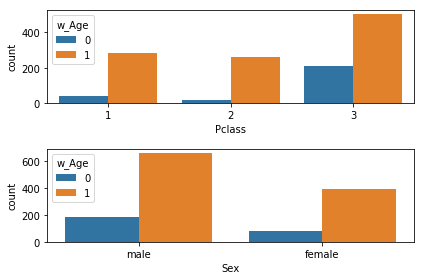

In [40]:
data['w_Age']=data['Age'].isnull().map(
    lambda x: 0 if x == True else 1)
pd.crosstab(data['w_Age'],data['Sex'],margins=True)
plt.subplot(2,1,1)
sns.countplot(data['Pclass'],hue=data['w_Age'])
plt.subplot(2,1,2)
sns.countplot(data['Sex'],hue=data['w_Age'])
plt.tight_layout()

We can see that most missing value is in PClass 3. To avoid noise in Age,
we should only look at the data in PClass 1 and 2.

The next question is how much Age is related to the Survival rate.

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


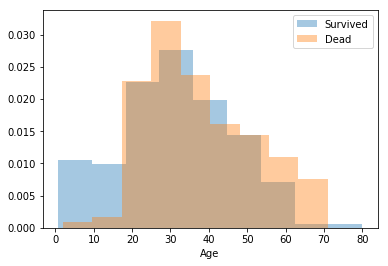

In [46]:
PClass_not3_survive_logic=((data['w_Age']==1)&(data['Pclass']!=3)&
                           (data['Survived']==1))
PClass_not3_die_logic=((data['w_Age']==1)&(data['Pclass']!=3)&
                       (data['Survived']==0))
sns.distplot(data.loc[PClass_not3_survive_logic,'Age'],
                  kde=False,bins=9,norm_hist=True,label='Survived')
sns.distplot(data.loc[PClass_not3_die_logic,'Age'],
                  kde=False,bins=9,norm_hist=True,label='Dead')
plt.legend()
plt.show()

Can see that only age <18 is meaningful. Including data older than 18 yrs old will only introduce noise to the system.

But still, there're lots of missing data if we wanna seperate the data into groups of <18 and >18.

There're hints in the titles of ppl which suggests the possible range of age of them.

Use median of age in the corresponding title to fill the missing age.

In [54]:
data['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [55]:
data['Title']=data[
    'Name'].str.extract('([A-Za-z]+)\.') #extract the titles
data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [56]:
data['Title'] = data['Title'].replace([
    'Don', 'Rev', 'Dr',
    'Major','Sir', 'Col', 'Capt', 'Countess',
    'Jonkheer', 'Dona'],'Rare') 
data['Title'].replace(['Mlle', 'Ms','Mme'],'Miss',inplace=True)
data['Title'].replace('Lady','Mrs',inplace=True)
data['Title']=data['Title'].map({
    "Mr":0, "Rare" : 1, "Master" : 2,"Miss" : 3, "Mrs" : 4})

In [57]:
# the median age of each title 
title_med=data.groupby('Title')['Age'].median()
print(title_med)

Title
0    29.0
1    47.0
2     4.0
3    22.0
4    36.0
Name: Age, dtype: float64


In [58]:
#fill the missing age accroding to the title of the person

data['fill_age']=data['Age'] 
# just to avoid changing the original data set

for i in title_med.index:
    data.loc[(data['Age'].isnull())&(data['Title']==i),
             'fill_age']=title_med[i]
data['fill_age']=data['fill_age'].astype('int')
data['is_minor']=(data['fill_age']<16)*1

In [162]:
#splits for train and test
train=data[:len(train)]
test=data[len(train):]

# for model fit
X_trn = train.drop(labels=['Survived','PassengerId'],axis=1)
Y_trn = train['Survived']

concerned_col=['Sex_Code','Pclass','FareBin_Code_5',
         'Connected_Survival','is_minor']
model=RandomForestClassifier(random_state=2,n_estimators=250,
                             min_samples_split=20,oob_score=True)
model.fit(X_trn[concerned_col],Y_trn)
print('minor oob score :%.5f' %(model.oob_score_))

minor oob score :0.84624


In [161]:
# Try other classification methods: Linear SVM (LinearSVC) 
# and KernalSVM (SVC)

SVM_model=LinearSVC()
SVM_model.fit(X_trn[concerned_col],Y_trn)

print('Linear SVM score=',SVM_model.score(X_trn[concerned_col],Y_trn))

kernel_SVM_model=SVC(kernel='rbf') #radial basis fun mapping
kernel_SVM_model.fit(X_trn[concerned_col],Y_trn)

print('Kernel SVM score=',kernel_SVM_model.score(
    X_trn[concerned_col],Y_trn))

Linear SVM score= 0.8204264870931538
Kernel SVM score= 0.8473625140291807


In [163]:
#submit
X_submit=test.drop(labels=['PassengerId'],axis=1)
Y_pred=model.predict(X_submit[concerned_col])
submit=pd.DataFrame({"PassengerId":test["PassengerId"],
                     "Survived":Y_pred.astype(int)})
submit.to_csv('submit_is_minor.csv',index=False)

In [164]:
submit.head()

,PassengerId,Survived
891,892,0
892,893,1
893,894,0
894,895,0
895,896,1


In [153]:
#submit (kernel SVM model)
X_submit=test.drop(labels=['PassengerId'],axis=1)
Y_pred=kernel_SVM_model.predict(X_submit[concerned_col])
submit=pd.DataFrame({"PassengerId":test["PassengerId"],
                     "Survived":Y_pred.astype(int)})
submit.to_csv('submit_is_minor_kernel.csv',index=False)